# Volatility Smile

This notebook is adressed to show ways to model the volatility smile, a phenomena present in the implied volatilities of options with the same maturity and different strikes.

## Our Data

Our data will be the implied volatilities for different options (with same maturities and different strikes).

The volatilities are for a Maturity of 1 Week.

We usually work with x values for modelling the volatility (when using for example the SVI model).

In [246]:
from math import log, exp, sqrt

Strikes = [80, 85 , 90 , 95 , 97.5 ,100 , 102.5, 105, 110, 115, 120
]
Spot = 100

x_values = [log(i/Spot) for i in Strikes]

w_vol = [52.79,41.02,28.5,18.27,12.5,6.99,7.83,13.2,
         22.53,31.86,40.59]

print('Volatility:',w_vol, '\n')
print('Log(Spot/K):',x_values)

Volatility: [52.79, 41.02, 28.5, 18.27, 12.5, 6.99, 7.83, 13.2, 22.53, 31.86, 40.59] 

Log(Spot/K): [-0.2231435513142097, -0.16251892949777494, -0.10536051565782628, -0.05129329438755058, -0.025317807984289897, 0.0, 0.024692612590371414, 0.04879016416943204, 0.09531017980432493, 0.13976194237515863, 0.1823215567939546]


In [247]:
x_test = [i/100 for i in range(-22,18,1)]
print(x_test)

[-0.22, -0.21, -0.2, -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17]


Let see how our vols look like.

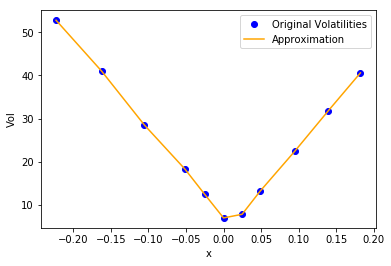

In [248]:
import matplotlib.pyplot as plt

def plot_vols(a, b, c = x_values, d = w_vol):    
    plt.plot(c,d, 'bo', label = 'Original Volatilities')
    plt.plot(a, b, color = 'Orange', label = 'Approximation')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Vol')
    plt.show()
    
def plot_error(a,b):
    plt.plot(a, b)
    plt.xlabel('x')
    plt.ylabel('error %')
    plt.show()
    
plot_vols(x_values, w_vol)

## First approximation: linear interpolation

A first way to model the smile of volatility is using a linear interpolation. 

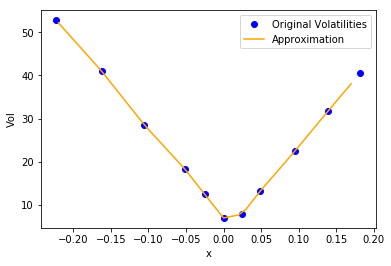

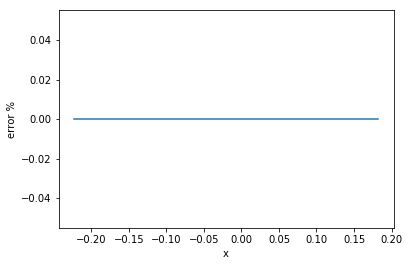

In [249]:
from scipy.interpolate import interp1d

vol_f_linear =  interp1d(x_values,w_vol)
w_linear = [vol_f_linear(i) for i in x_values]
w_linear_test = [vol_f_linear(i) for i in x_test]
plot_vols(x_test, w_linear_test)

error = [100*(a-b) / b for a,b in zip(w_linear,w_vol)]
plot_error(x_values,error)

The main problem with the linear interpolation is the possbility of calendar spread arbitrage. So in order to avoid this we have to use a better approximation. Also the shape is not very smooth so it introduces other types of arbitrages.

## Cubic Spline

The next way to model the smile is using a cubic spline. This is a common and very simple approximation for the volatility smile. 

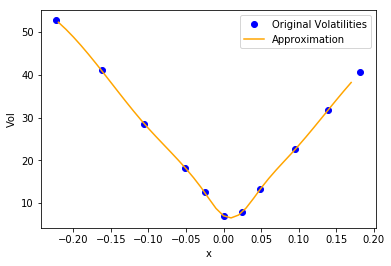

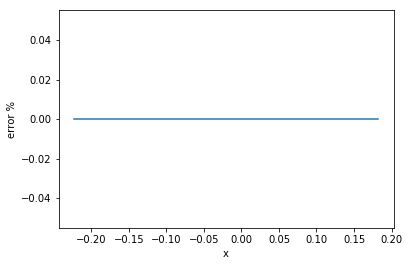

In [250]:
from scipy.interpolate import CubicSpline

vol_f_spline =  CubicSpline(x_values,w_vol)
w_spline = [vol_f_spline(i) for i in x_values]
w_spline_test = [vol_f_spline(i) for i in x_test]
plot_vols(x_test, w_spline_test)



error = [100*(a-b) / b for a,b in zip(w_spline,w_vol)]
plot_error(x_values,error)

## SVI

SVI stands for Stochastic Volatility Inspired. This is a model with 5 parameters that approximates the volatility inspired in the Heston Stochastic Volatility model. There is a great paper on modelling the volatility smile by the KTH. I recommend reading it:

https://www.math.kth.se/matstat/seminarier/reports/M-exjobb14/140909.pdf

The approach showed here is less sofisticated than the one present in the paper, however the main ideas are present.

The SVI is modelled in the following function.

In [251]:
def svi(a,b,rho,m,vol,x_val):
    return a + b*(rho*(x_val-m) + sqrt((x_val-m)**2 + vol**2))

In order to use the model we have to find the values of a, b, rho, m and vol. To do so we will fit them to the volatilities using the following functions. 

The first one calculates the error with respect the volatilities.

In [252]:
def compute_error_SVI(x, x_values, w_vol):
    a = x[0]
    b = x[1]
    rho = x[2]
    m = x[3]
    vol = x[4]
    error = 0
    for x_val, w in zip(x_values,w_vol):
        w_calc = svi(a,b,rho,m,vol,x_val)
        error += (w_calc - w)**2        
    return error

Then we will set the parameters for the calibration. We have one constraint (for the volatility) and the bounds of every parameter.

In [253]:
thau = 1/54 # the maturity of the options.
cons = ({'type': 'ineq', 'fun': lambda x:  -x[1] + 4/(thau*(1+abs(x[2])))})
bnds = ((0, max(w_vol)), (0, None), (-1,1), (2*min(x_values),2*max(x_values)),
        (0,10))

Finally we will realize the optimization to find the best parameters.

In [254]:
import scipy.optimize as optimize
x = optimize.minimize(compute_error_SVI, [0,0,0,0,0],constraints = cons, 
                      bounds = bnds, method='L-BFGS-B',args = (x_values, w_vol),
                      options={ 'disp': True})

In [255]:
print(f'a: {x.x[0]} \nb: {x.x[1]} \nrho: {x.x[2]} \nm: {x.x[3]} \nvol: {x.x[4]}')

a: 5.0917827142684144 
b: 206.01162153921328 
rho: 0.0049945812518729805 
m: 0.010703457159342447 
vol: 0.0


Let's see how they are plotted.

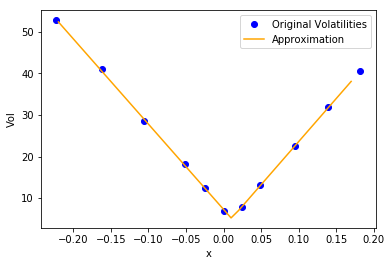

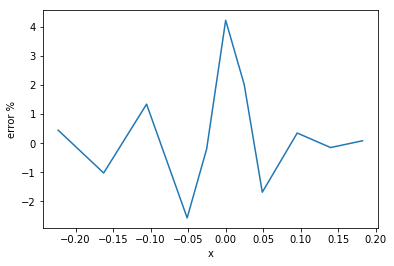

In [256]:
w_svi = [svi(x.x[0],x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_values]
w_svi_test = [svi(x.x[0],x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_test]
plot_vols(x_test, w_svi_test)
error = [100*(a-b) / b for a,b in zip(w_svi,w_vol)]
plot_error(x_values,error)

As we see we have a big spike due to the minimization. We wanted so much to fit the curve to the initial vol term structure that we end up with a big spike. If we check the fitting of the curve to the initial points we can see that it is very good but the shape of the overall smile is quite bad... We will try to fix it afterwards, first we want to understand what the parameters mean in the composition of the smile.

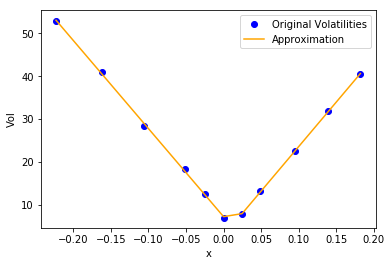

In [257]:
plot_vols(x_values, w_svi)

### How are the parameters affecting the smile?

Let's change every parameter to find it.

First we will play with the a.

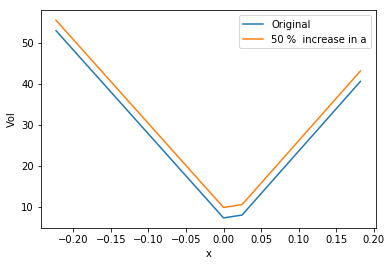

In [258]:
w_svi_a = [svi(x.x[0]*1.5,x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_a, label = '50 %  increase in a')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

So an increase in a means a translation of the curve upwards. Which is logical if you check the formula.

Let's see what happens with the b.

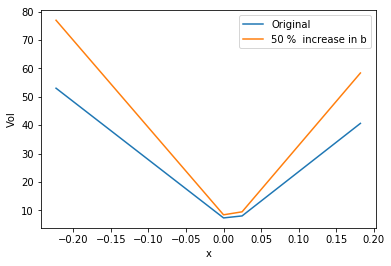

In [259]:
w_svi_b = [svi(x.x[0],1.5*x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_b, label = '50 %  increase in b')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

An increase of the b makes the smile of the curve narrower.

What about the rho?

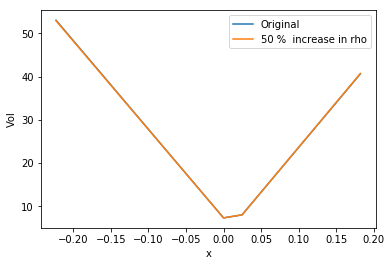

In [260]:
w_svi_rho = [svi(x.x[0],x.x[1],1.5*x.x[2],x.x[3],x.x[4],i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_rho, label = '50 %  increase in rho')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

First try no success, let's try with a bigger increase then...

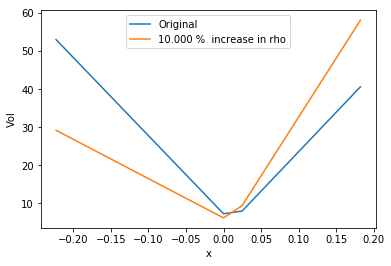

In [261]:
w_svi_rho = [svi(x.x[0],x.x[1],100*x.x[2],x.x[3],x.x[4],i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_rho, label = '10.000 %  increase in rho')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

Much better... Now we see that increasing the rho produces a rotation counter clockwise of the smile.

Let's play with the m.

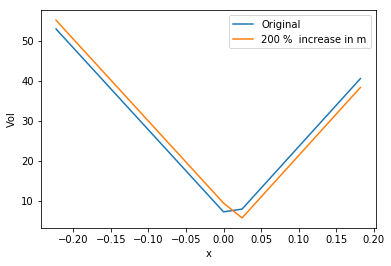

In [262]:
w_svi_rho = [svi(x.x[0],x.x[1],x.x[2],2*x.x[3],x.x[4],i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_rho, label = '200 %  increase in m')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

An increase of m generates a translation in the x-axis of the smile.

Last but not least we will see what happens with the sigma or vol.

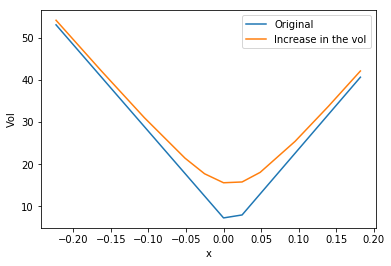

In [263]:
w_svi_rho = [svi(x.x[0],x.x[1],x.x[2],x.x[3],0.05,i) for i in x_values]
plt.plot(x_values, w_svi, label = 'Original')
plt.plot(x_values, w_svi_rho, label = 'Increase in the vol')
plt.xlabel('x')
plt.ylabel('Vol')
plt.legend()
plt.show()

Finally we can see that increasing the vol makes the curve more smooth and augments the atm vols.

----------
In summary we can reduce the interactions of the parameters into:


* Increasing a: translation in y-axis.
* Increasing b: narrows the smile.
* Increasing rho: counter clockwise rotation.
* Increasing m: translation in x-axis.
* Increasing vol (a lot): higher atm vol.

#### Fixing the spike in the smile

In order to get a more smooth smile we can do different things:
* Get more data: the more points we have the better the fitting will be, however in this case we ran out of datapoints.
* Enforce a higher vol: now we know that increasing the vol will result in a smoother curve so let's impose that boundary in the optimization and see what can we get.

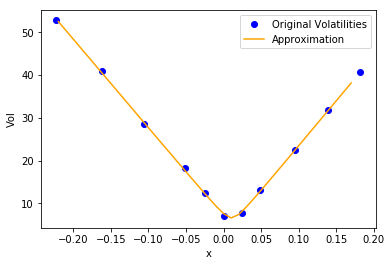

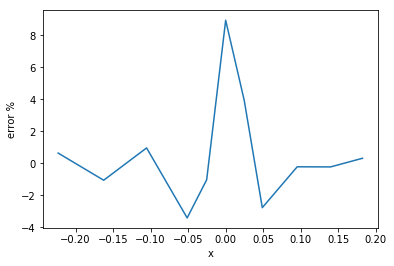

In [264]:
thau = 1/54 # the maturity of the options.
cons = ({'type': 'ineq', 'fun': lambda x:  -x[1] + 4/(thau*(1+abs(x[2])))})
bnds = ((0, max(w_vol)), (0, None), (-1,1), (2*min(x_values),2*max(x_values)),
        (0.0095,10))
x = optimize.minimize(compute_error_SVI, [0,0,0,0,0],constraints = cons, 
                      bounds = bnds, method='L-BFGS-B',args = (x_values, w_vol),
                      options={ 'disp': True})
w_svi= [svi(x.x[0],x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_values]
w_svi_test = [svi(x.x[0],x.x[1],x.x[2],x.x[3],x.x[4],i) for i in x_test]
plot_vols(x_test, w_svi_test)
error = [100*(a-b) / b for a,b in zip(w_svi,w_vol)]
plot_error(x_values,error)

Now we have a much better smile however the increase in the error is significant, a tradeoff like always...

## SABR Model

This model is quite used for modelling short expiration volatility surfaces for FX and IR markets. It models the behaviour of a future / forward price. For the sake of convenience we will use the same data to be able to compare it with the rest of the models.

There are many papers on SABR model so if you want to know more about just google it. 

Haug has a fantastic book called The complete guide to *Option Pricing Formulas* and I will use the formulas appearing there.

We basically have 4 parameters: beta, alfa, xi and rho. In fact the model was called SABR for Stochastic Alpha Beta Rho.

#### Brute Force Approximation

To calibrate the parameters a first way to do so is just to minimize the error so the curve can fit all the values.

Usually beta is chosen by the trader, 0 for FI markets and 1 for Fx market.

In [265]:
def SABR_vol(alfa,beta,rho,xi,x, thau):
    Spot = 100
    K = exp(x) * Spot
    
    if abs(x) <= 1e-8 :
        return alfa / (Spot**(1-beta)) *(((1-beta)**2 /24 ) * 
                                         (alfa**2)/(Spot**(2-2*beta)) + 0.25*rho*beta*alfa*xi / 
                                         (Spot**(1-beta)) + (2-3*rho**2)/24 *xi**2)*thau
        
    else:
        z = (xi / alfa) * (Spot*K)**((1-beta)/2)*x #bien
        chi = log((sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho)) #bien
        first_term  = (alfa * (z / chi)) / (((Spot*K)**(0.5-0.5*beta)) *(1 + (((1-beta)**2 /
                                                                 24 ) * x**2 ) + ((((1-beta)**4)* x**4) / 1920)))  
        second_term = (1+ ( ((1-beta)**4 / 24)*((alfa**2) / ((Spot*K)**(1-beta)) ) 
                       + 0.25*(rho*beta*xi*alfa)/((Spot*K)**(0.5-0.5*beta)) + ((2-3*rho**2)*(xi**2))/24 )*thau)
    
        return first_term*second_term

def compute_error_SABR(x,x_values, w_vol, beta, thau):
    alfa = x[0]
    rho = x[1]
    xi = x[2]
    error = 0
    for x_val, w in zip(x_values,w_vol):
        w_calc = SABR_vol(alfa,beta,rho,xi,x_val, thau)
        error += (w_calc - w)**2        
    return error

thau = 1/54 # the maturity of the options.
beta =  0 # For convenience.
bnds = ((1e-8, None), (0, 0.999), (1e-8,None))
x = optimize.minimize(compute_error_SABR, [0,0,0], 
                      bounds = bnds, method='L-BFGS-B',args = (x_values, w_vol, beta, thau))
print(x)

      fun: 19.721847429243294
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.45545856e-05,  1.28665079e-02, -5.01643171e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 184
      nit: 26
   status: 0
  success: True
        x: array([46.48023529,  0.23202701, 85.27258252])


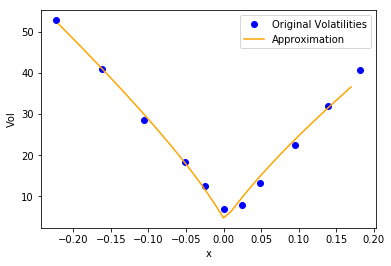

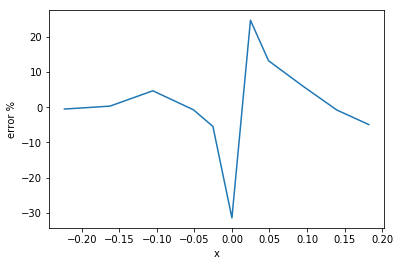

In [266]:
w_SABR= [SABR_vol(x.x[0],beta,x.x[1],x.x[2],i, thau) for i in x_values]
w_SABR_test = [SABR_vol(x.x[0],beta,x.x[1],x.x[2],i, thau) for i in x_test]
plot_vols(x_test, w_SABR_test)
error = [100*(a-b) / b for a,b in zip(w_SABR,w_vol)]
plot_error(x_values,error)

One problem that we find with this approximation is the inestability of the optimization. If we put 1 as a limit for rho it does not reach convergence. The same happens if we use a beta = 0. We should dig deeper maybe on the boundaries.

#### Usual procedure

In order to calibrate the model it is quite common to fix the value of the alpha so that it matches the atm vol for a given v (which we will put as a parameter) and rho. So let's do it.

In [267]:
def compute_error_SABR(x,x_values, w_vol, beta, thau):
    alfa = x[0]
    rho = x[1]
    xi = x[2]
    error = 0
    for x_val, w in zip(x_values,w_vol):
        w_calc = SABR_vol(alfa,beta,rho,xi,x_val, thau)
        error += (w_calc - w)**2        
    return error


def alpha_SABR_wihtout_v(x):
    alfa = x[0]
    rho = x[1]
    Spot = 100
    xi = x[1]
    v = x[3]
    vol_atm = x[4]
    thau = x[5]
    beta = x[6]
    return (alfa / (Spot**(1-beta))) *(1+(((1-beta)**2 /24 ) * 
                                         (alfa**2)/(Spot**(2-2*beta)) + 0.25*rho*beta*alfa*xi / 
                                         (Spot**(1-beta)) + (2-3*rho**2)/24 *xi**2)*thau) - vol_atm


thau = 1/54 # the maturity of the options.
beta =  0 # For convenience.
vol_atm = 6.99
cons = ({'type': 'ineq', 'fun': lambda x: alpha_SABR_wihtout_v(x)})
bnds = ((1e-8, None), (0, 0.999), (1e-8,None), (None,None), (vol_atm,vol_atm), (thau,thau), (beta,beta))
x = optimize.minimize(compute_error_SABR, [0,0,0,0,vol_atm,thau, beta], constraints = cons, 
                      bounds = bnds, method='L-BFGS-B',args = (x_values, w_vol, beta, thau))
print(x)

      fun: 19.721847429243294
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.45545856e-05,  1.28665079e-02, -5.01643171e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 368
      nit: 26
   status: 0
  success: True
        x: array([4.64802353e+01, 2.32027008e-01, 8.52725825e+01, 0.00000000e+00,
       6.99000000e+00, 1.85185185e-02, 0.00000000e+00])


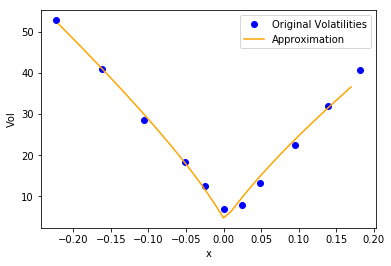

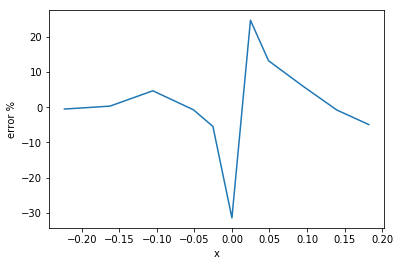

In [268]:
w_SABR = [SABR_vol(x.x[0],beta,x.x[1],x.x[2],i, thau) for i in x_values]
w_SABR_test = [SABR_vol(x.x[0],beta,x.x[1],x.x[2],i, thau) for i in x_test]
plot_vols(x_test, w_SABR_test)
error = [100*(a-b) / b for a,b in zip(w_SABR,w_vol)]
plot_error(x_values,error)

Note for the observer 
--------------------------------

As it can be seen scipy is ignoring my restriction so I have not been able to impose the SABR model to fit the atm vol. We will have to try something different. A good solution would be to impose xi and rho so that we can directly calculate alpha.

A good alternative would be to look for another optimizer.

In [269]:
def SABR_vol_alpha(x, vol_atm,thau, beta, rho, xi,logx):
    Spot = 100
    alfa = x[0]
    K = exp(logx) * Spot
    

    return alfa / (Spot**(1-beta)) *(((1-beta)**2 /24 ) * 
                                         (alfa**2)/(Spot**(2-2*beta)) + 0.25*rho*beta*alfa*xi / 
                                         (Spot**(1-beta)) + (2-3*rho**2)/24 *xi**2)*thau -vol_atm


# We put the values that we obtained previously
thau = 1/54 # the maturity of the options.
beta =  0 # For convenience.
vol_atm = 6.99
Spot = 100
rho = 2.32027008e-01
xi = 8.52725825e+01
initial_alpha = 4.64802353e+01

from scipy.optimize import minimize_scalar, root
logx = log(1)
x = root(SABR_vol_alpha, x0 = initial_alpha,   args = (vol_atm,thau, beta, rho, xi,logx))
print(x)

    fjac: array([[-1.]])
     fun: 8.881784197001252e-16
 message: 'The solution converged.'
    nfev: 5
     qtf: array([1.62782676e-09])
       r: array([-0.10316205])
  status: 1
 success: True
       x: array([67.762132])


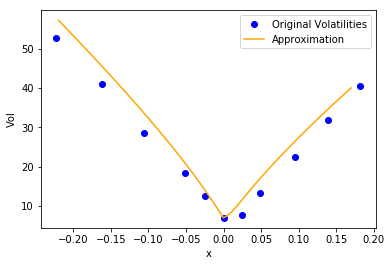

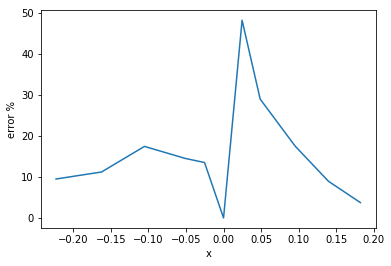

In [270]:
alfa = 67.762132
w_SABR= [SABR_vol(alfa,beta,rho,xi,i, thau) for i in x_values]
w_SABR_atm_vol = [SABR_vol(alfa,beta,rho,xi,i, thau) for i in x_test]
plot_vols(x_test, w_SABR_atm_vol)
error = [100*(a-b) / b for a,b in zip(w_SABR,w_vol)]
plot_error(x_values,error)

So we finally got what we were expecting, we have calibrated the alpha to match the atm vols.

## Comparing the Smiles

#### Linear interpolation

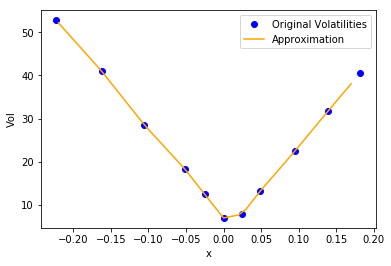

In [271]:
plot_vols(x_test, w_linear_test)

#### Cubic Spline

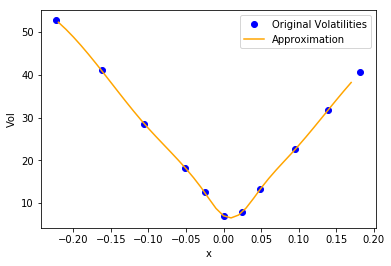

In [272]:
plot_vols(x_test, w_spline_test)

#### Direct SVI

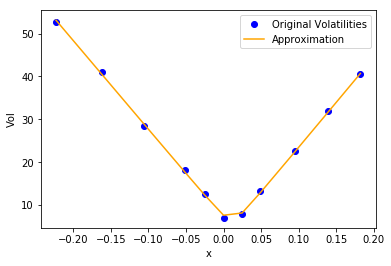

In [273]:
plot_vols(x_values, w_svi)

#### Tuned SVI

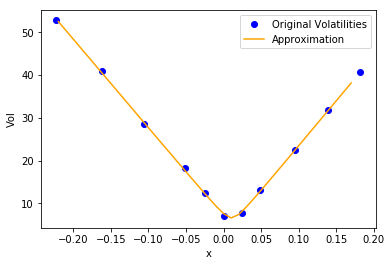

In [274]:
plot_vols(x_test, w_svi_test)

#### Brute Force SABR

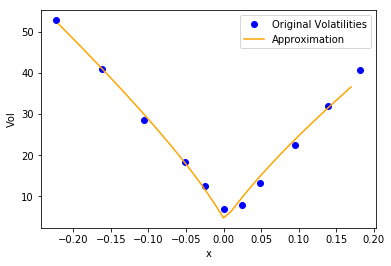

In [275]:
plot_vols(x_test, w_SABR_test)

#### ATM Calibrated SABR

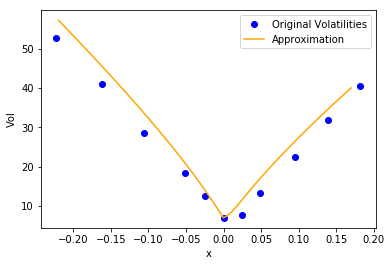

In [276]:
plot_vols(x_test, w_SABR_atm_vol)